## 新闻联播文本数据挖掘分析
参考模版：[基于1957—2022年太空探索记录的数据可视化项目](https://mp.weixin.qq.com/s/YRwq08D3aF5LAvBK9nIGsA)
新闻联播作为中国大陆最具有权威性的新闻节目，承载着一代又一代人的记忆。其每日播报的内容蕴藏着中国社会的变化线索。
使用大数据的分析范式，对新闻联播的文本数据进行时间序列分析会是一个很有趣的数字人文探索实践。

参考借鉴了   https://1118.cctv.com/2016/10/20/ARTIIaWAsmLhiXDFiWFsbsRr161020.shtml     的分析思路

本笔记关注新闻数据中出现的地理名词，基于地理名词十年来的词频统计，试图解释这些城市在国家政治、经济或社会方面的重要性。


In [7]:
# Package Preperation

# Supress Warnings
import warnings
warnings.filterwarnings("ignore")
# 数据获取Web-Spider
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import random
import time
# 数字可视化工具
import plotly.express as px
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 文本分析处理可视化工具
import jieba
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.lda_model
import os
# https://blog.csdn.net/a18307096730/article/details/121586034
from pyecharts.charts import Map
from pyecharts import options as opts

### 1 数据获取
基于[哪个城市是中央眼中的心头爱？基于新闻联播文本的大数据分析](https://mp.weixin.qq.com/s/EvhdkXQBHZVYenYg1U74YQ)中的代码改进了爬虫。我们采集的数据范围为2022年6月1日至2024年的3月18日。

在爬取的数据中，由于网站设置的问题，缺失了2022年6月21日和2022年7月15日的新闻文本数据。这种缺失对较大的数据集影响不大。

In [3]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import random
import time

# Function to extract details from a video link
def web_crawler_():
    def get_video_details(video_url):
        res_video = requests.get(video_url, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'})
        res_video.encoding = 'utf-8'
        soup_video = BeautifulSoup(res_video.text, 'html.parser')
        title = soup_video.find('title').text
        description = soup_video.find('meta', {'name': 'description'})['content']
        source = soup_video.find('span', class_='laiyuan').text
        time = soup_video.find('span', class_='time').text
        content = soup_video.find('div', id='content_area').text.strip()
        return f"标题: {title}\n描述: {description}\n来源: {source}\n时间: {time}\n内容: {content}"

    # Initialize DataFrame
    df = pd.DataFrame(columns=['Video Title', 'Video Link', 'Video Image', 'Video Duration', 'Details'])

    # Specify the date range
    start_date = datetime.strptime('20240312', '%Y%m%d') # 在这里更改收集开始日期
    end_date = datetime.strptime("20240318",'%Y%m%d') # 在这里更改收集结束日期

    # Iterate over each day in the date range
    while start_date <= end_date:
        date_str = start_date.strftime('%Y%m%d')
        url = f'https://tv.cctv.com/lm/xwlb/day/{date_str}.shtml'

        # Fetch HTML content with random delay
        time.sleep(random.uniform(0.1, 0.3))  # Random delay between 0.8 and 1.2 seconds
        res = requests.get(url, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'})
        res.encoding = 'utf-8'
        html_code = res.text
        soup = BeautifulSoup(html_code, 'html.parser')

        # Temporary list to store data
        temp_data = []

        # Extract information from each video entry
        for li in soup.find_all('li'):
            a_tag = li.find('a', {'alt': True})
            if a_tag:
                video_title = a_tag.get('alt')
                video_link = li.find('a', {'href': True}).get('href')
                video_image = li.find('img').get('src')
                video_duration = li.find('span').text

                # Fetch video details with random delay
                time.sleep(random.uniform(0.8, 1.2))  # Random delay between 0.8 and 1.2 seconds
                details = get_video_details(video_link)

                # Append data to temporary list
                temp_data.append({'Video Title': video_title,
                                  'Video Link': video_link,
                                  'Video Image': video_image,
                                  'Video Duration': video_duration,
                                  'Details': details})

        # Concatenate temporary data to the DataFrame
        if temp_data:
            df = pd.concat([df, pd.DataFrame(temp_data)], ignore_index=True)

        # Save DataFrame to CSV
        df.to_csv(f'videos_{date_str}.csv', index=False)

        # Clear the DataFrame for the next iteration
        df = pd.DataFrame(columns=['Video Title', 'Video Link', 'Video Image', 'Video Duration', 'Details'])

        # Move to the next day
        start_date += timedelta(days=1)

# web_crawler_()


### 2. 数据预处理
数据收集完毕我们需要将数据集转化成易为分析和处理的数据表格式。步骤：
1. 合并数据表：上面的网页爬取步骤只能够爬取一日一日的网页，一个网页形成一张表格。为了批量处理数据，我们将近2年的数据整合成一张大表。

2. 细节信息提取：我发现合并数据表的Detail栏目下所有的内容基本都遵循如下样板：
> **描述**: [视频]国际联播快讯
> 
> **来源**: 来源 : 央视网
> 
> **时间**: 2024-03-11 19:36
> 
> **内容**: 央视网消息（新闻联播）：俄称巩固战场优势 乌称打击俄防空系统俄罗斯国防部10日称，俄军在库皮扬斯克方向巩固优势；在顿涅茨克和阿夫杰耶夫卡方向占据更为有利形势。俄军还拦截多枚“海马斯”火箭弹，摧毁乌军130架无人机。乌克兰方面称，乌空军对俄军多个人员及军事装备集中区、防空系统等实施了打击。波兰外长西科尔斯基近日表示，来自北约国家的士兵已经出现在乌克兰。对此俄罗斯外交部发言人扎哈罗娃10日表示，北约国家在乌克兰的军事存在已经无法隐瞒。法国东南部遭遇风暴 3人死亡4人失踪法国东南部近日遭遇风暴袭击，多地出现强降雨引发的洪水灾害。据法国媒体10日报道，目前恶劣天气已经导致3人死亡，另有包括两名儿童在内的4人失踪。在阿尔代什省，由于水流太大，搜救工作10日晚被迫停止。"
因此，使用模糊匹配，将内容单独拆分出为独一栏。

3. 去除空值：网络爬虫爬取字符串输入至表格。为了预防空字符串破坏我们的数字人文探索实践，将含有空字符串的新闻纪录予以删除。

In [4]:
# 数据表合并
def concat_date_df(startDate, endDate):
    # 初始化
    # Specify the date range
    start_date = datetime.strptime(startDate, '%Y%m%d')
    end_date = datetime.strptime(endDate,'%Y%m%d')
    concat_df = pd.DataFrame(columns=["Time", "Video Title", "Video Duration", "Detail"])

    for single_date in pd.date_range(start=start_date, end=end_date, freq='D'):
        date_str = single_date.strftime("%Y%m%d")
        filename = f'./videos_{date_str}.csv'
        try:
            #每一个df的第一行是的title都是“新闻联播”,不是我们要分析的对象。
            df = pd.read_csv(filename).loc[1:,]
            
            df['Time'] = date_str
            
            concat_df = pd.concat([concat_df,df],ignore_index = True)
        except FileNotFoundError:
            print(f"文件 {filename} 不存在")

    return concat_df


df = concat_date_df("20220601","20240318")
df.drop(["Detail","Video Link","Video Image"],
        axis = 1,
        inplace = True)
#对于每一个Detail, 总有“标题”、“描述”、“来源”、“时间”、“内容”这几个要素，因此把这部分内容拆开
pattern = r'描述: (?P<描述>.*?)\n来源: (?P<来源>.*?)\n时间: (?P<时间>.*?)\n内容: (?P<内容>.*)'

# 使用 str.extract() 方法应用正则表达式并拆分 Details 列
details_split = df['Details'].str.extract(pattern)

# 将拆分后的 DataFrame 合并回原始的 df
df = pd.concat([df.drop(columns=['Details']), details_split], axis=1)

# 观察到 Video Title 和 “描述” 是重合的，此外，“来源”和“时间“的信息我们并不感兴趣，因此也去除。
df = df.drop(["描述","来源","时间"],axis=1)

# “内容”部分的开头总有“央视网消息（新闻联播）：”这些文字，对分析没有什么用，也去除
df['内容'] = df['内容'].str.replace("^央视网消息（新闻联播）：", "", regex=True)

# “Video Title” 中的“[视频]”同理
df['Video Title'] = df['Video Title'].str.replace("\[视频\]", "", regex=True)


def remove_rows_with_empty_strings(df):
    # 将所有的空字符串格转化成NaN
    df.replace('',np.nan,inplace=True)
    df.dropna(axis=0,how='any',inplace=True)

remove_rows_with_empty_strings(df)

# 检查是否存在空值或者空字符串
print(f"Total NaN for each column\n{df.isnull().sum()}")

<>:45: DeprecationWarning: invalid escape sequence '\['
<>:45: DeprecationWarning: invalid escape sequence '\['
/var/folders/k0/sqlrb6tx7w77mv29j7333kyh0000gq/T/ipykernel_18937/2472957990.py:45: DeprecationWarning: invalid escape sequence '\['
  df['Video Title'] = df['Video Title'].str.replace("\[视频\]", "", regex=True)


文件 ./videos_20220621.csv 不存在
文件 ./videos_20220705.csv 不存在
Total NaN for each column
Time              0
Video Title       0
Video Duration    0
内容                0
dtype: int64


In [5]:
df['Time'] = pd.to_datetime(df['Time'], format='%Y%m%d').dt.to_period('D')
display(df.tail())

,Time,Video Title,Video Duration,内容
9433,2024-03-18,国内联播快讯,00:03:04,境外来华人士数字人民币支付指南发布中国人民银行今天（3月18日）发布境外来华人士数字人民币支...
9434,2024-03-18,普京当选连任俄罗斯总统,00:01:06,俄罗斯中央选举委员会今天（3月18日）表示，俄总统选举已完成99.59%的选票统计，结果显示...
9435,2024-03-18,以军在加沙城希法医院地区展开行动 巴武装人员击落以军无人机,00:01:22,据巴勒斯坦媒体今天（3月18日）报道，以军对加沙地带北部加沙城多个区域发动了袭击，目标包括希...
9436,2024-03-18,俄称控制顿涅茨克方向一定居点 乌称打击俄多个目标,00:00:42,俄罗斯国防部17日称，俄军在阿夫杰耶夫卡、赫尔松等方向击退乌军攻势，在顿涅茨克南部方向控制了...
9437,2024-03-18,国际联播快讯,00:01:59,西班牙波兰农民继续抗议欧盟农业政策来自西班牙的上千名农民等人员17日在首都马德里举行集会，用...


### 3. 基本描述性统计分析
数据集的几个重要特征：
1. 总共收录了9434条新闻。
2. 9434条新闻中，独特的标题有7809条。标题最多的标题是“国内联播快讯”
3. 总共收录了655天的新闻。其中，某一天总共播报了29条新闻，为所有日期中播报最多。

In [6]:
# 上述df就是我们需要分析的数据集。接下来数据集的基本特征进行探索（描述性统计）
# 描述性统计分析
print("描述性统计分析：")
print(df.describe())

# 对分类变量的统计
print("\nVideo Title统计:")
print(df['Video Title'].describe())

# 对时间变量的统计
print("\nTime统计:")
print(df['Time'].describe())

描述性统计分析：
              Time Video Title Video Duration  \
count         9434        9434           9434   
unique         655        7809            570   
top     2023-10-19      国内联播快讯       00:01:00   
freq            29         624            151   

                                                       内容  
count                                                9434  
unique                                               9433  
top     9月30日是国家设立的烈士纪念日，当天上午，习近平等党和国家领导人将同各界代表一起，在天安门...  
freq                                                    2  

Video Title统计:
count       9434
unique      7809
top       国内联播快讯
freq         624
Name: Video Title, dtype: object

Time统计:
count           9434
unique           655
top       2023-10-19
freq              29
Name: Time, dtype: object


这段代码是数字人文研究中的一个应用实例，它运用数据可视化技术来探索和展现新闻媒体对时间的关注度如何随时间变化。具体而言，这个分析聚焦于通过新闻视频时长的总和来量化每天的新闻关注度，从而洞察媒体关注的时间分布和变化趋势。代码的操作可以分为以下几个步骤：

数据预处理：首先，将日期列转换为datetime格式，以确保可以正确地对日期进行排序和处理。随后，对数据按日期进行排序，以保证时间序列的连续性。

数据分段：考虑到整个时间范围可能过长，导致在单一图表中显示时过于密集，这里将数据分为两部分进行展示。第一部分包含时间序列的前365天，第二部分包含剩余的天数。这种分段方式旨在提高可视化的清晰度和可读性，使观众能够更容易地理解数据展示的时间趋势。

绘制折线图：接着，使用seaborn库中的lineplot功能分别对这两部分数据绘制折线图。每个子图显示了一段时间内新闻视频时长总和随时间的变化，其中每一点代表一天的新闻时长总和，点之间通过线段相连，形成折线图。通过在两个子图中展示这些数据，研究者可以比较前后两段时间内媒体关注度的变化。

可视化调整：为了增强可视化的效果和信息的传达，代码还对图表进行了一系列的布局和样式调整，包括设置标题、调整轴标签和图例等，以确保图表信息清晰、易于理解。

这个分析示例展现了数字人文研究如何利用数字化工具和方法来分析和理解人文社会科学问题。通过量化分析新闻媒体的关注点，并以时间序列数据的形式可视化这些关注点的变化，研究者可以揭示出媒体关注的动态模式和潜在的社会文化因素，从而提供对人类行为和社会变迁的深入洞察。

/Users/walterwu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/Users/walterwu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/Users/walterwu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/Users/walterwu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



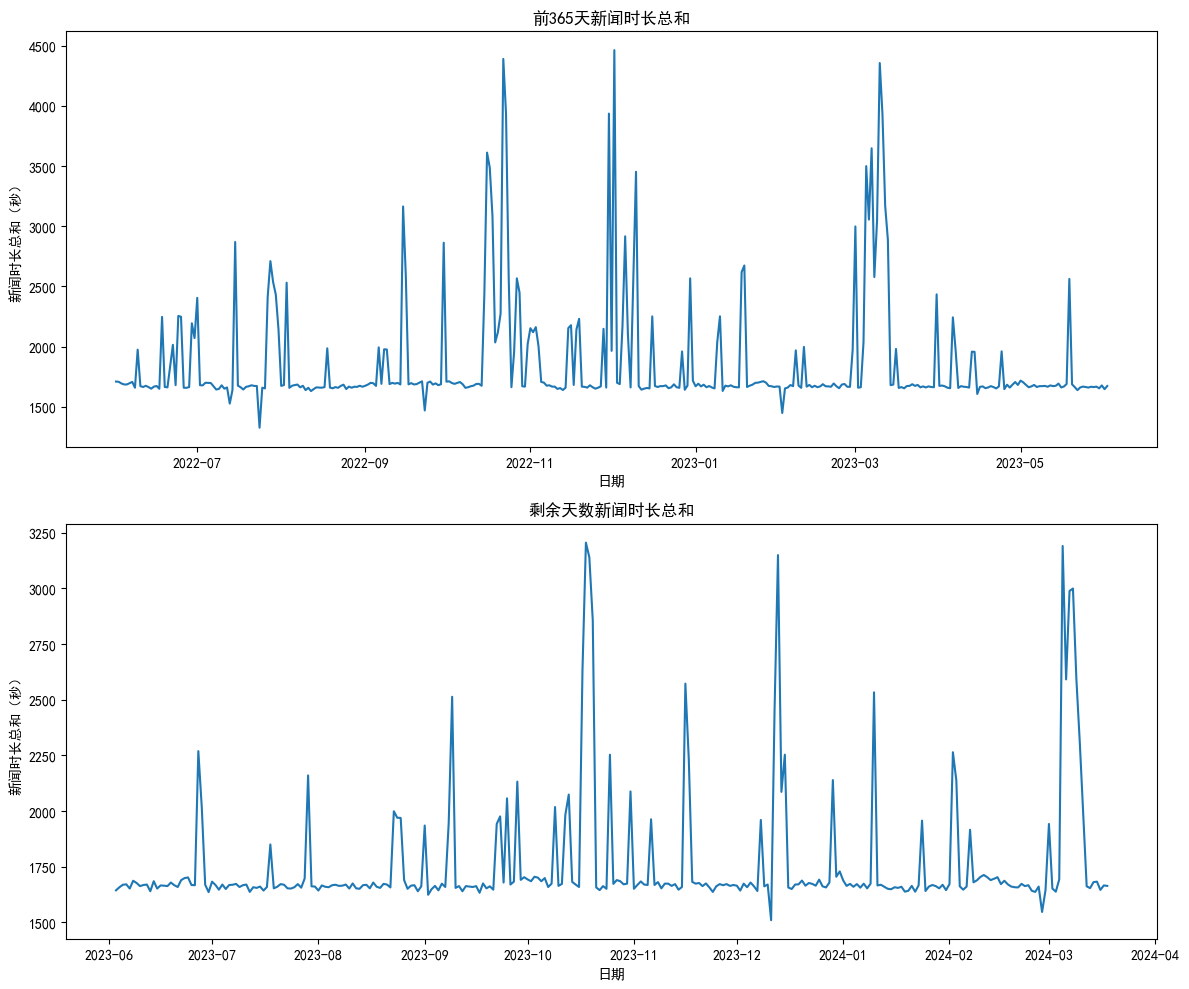

In [17]:
daily_sum['Date'] = pd.to_datetime(daily_sum['Date'])

# 对数据进行排序，以确保日期是连续的
daily_sum = daily_sum.sort_values(by='Date').reset_index(drop=True)

# 分割数据为两个部分
split_point = 365
if len(daily_sum) > split_point:
    part1 = daily_sum[:split_point]
    part2 = daily_sum[split_point:]
else:
    part1 = daily_sum
    part2 = pd.DataFrame()

# 创建画布和子图
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# 绘制第一个子图
sns.lineplot(data=part1, x='Date', y='Video Duration (seconds)', ax=axs[0])
axs[0].set_title('前365天新闻时长总和')
axs[0].set_xlabel('日期')
axs[0].set_ylabel('新闻时长总和（秒）')

# 绘制第二个子图
sns.lineplot(data=part2, x='Date', y='Video Duration (seconds)', ax=axs[1])
axs[1].set_title('剩余天数新闻时长总和')
axs[1].set_xlabel('日期')
axs[1].set_ylabel('新闻时长总和（秒）')

plt.tight_layout()
plt.show()

描述性统计分析一般要分别研究每一个属性的分布。我对Video Duration这个属性比较感兴趣。直觉来看，Video Duration的长度和重要性可能是正相关的。因此我只做了一个柱状图来描述新闻时长的分布。

统计的结果如下，你们可以拖动鼠标看看。

我对离群值比较感兴趣———哪些新闻需要被报道超过1000次以上呢？我做了一个过滤。选择了1000s以上的新闻。

In [8]:
def time_to_seconds(time_str):
    # Split the string into hours, minutes, and seconds
    h, m, s = map(int, time_str.split(':'))
    # Convert hours to seconds and add to total
    total_seconds = h * 3600
    # Convert minutes to seconds and add to total
    total_seconds += m * 60
    # Add seconds to total
    total_seconds += s
    return total_seconds

def hist_of_video_duration_improved(news_df):
    temp = news_df.copy()
    # 将时间字符串转换为秒数
    temp['Video Duration (seconds)'] = temp['Video Duration'].apply(time_to_seconds)

    # 使用Plotly Express绘制直方图
    fig = px.histogram(temp, 
                       x='Video Duration (seconds)', 
                       nbins=50, 
                       histfunc='count',
                       color_discrete_sequence=['#636EFA'])  # 更改直方图颜色

    # 设置x轴和y轴标签
    fig.update_xaxes(title_text='新闻时长（秒）', dtick=100)
    fig.update_yaxes(title_text='次数')

    # 调整图形布局
    fig.update_layout(title_text='新闻联播单条新闻时长分布',  # 设置标题
                      title_x=0.5,  # 将标题居中
                      legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
                      coloraxis_showscale=False)  # 关闭颜色条

    # 显示图形
    fig.show()

hist_of_video_duration_improved(df)# 生成改进后的视频时长分布直方图。

/Users/walterwu/anaconda3/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/walterwu/anaconda3/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



直方图中我们可以看到超过1000秒的新闻已经很稀少了。但是我很好奇超过1000秒的新闻究竟是哪些新闻（这种类型的新闻具有一定的典型性）。因此我抽取出来看看。

1000s的新闻只有14条。但是他们却在主题上高度地集中——按照降序排序之后。我们自然地能够知道为什么这个新闻是如此地重要。

（+1s）


In [26]:
def over_1000s_news_extract(news_df):
    temp = news_df.copy()
    temp['Video_duration(Seconds)'] = temp['Video Duration'].apply(time_to_seconds)
    return temp[temp['Video_duration(Seconds)'] >= 1000] 

news_over_1000s = over_1000s_news_extract(df).sort_values(by='Video_duration(Seconds)',ascending=False)
display(news_over_1000s)

def between_500s_1000s_news_extract(news_df):
    temp = news_df.copy()
    temp['Video_duration(Seconds)'] = temp['Video Duration'].apply(time_to_seconds)
    return temp[(temp['Video_duration(Seconds)'] >= 500) & (temp['Video_duration(Seconds)'] < 1000)] 
news_between_500s_1000s = between_500s_1000s_news_extract(df).sort_values(by='Video_duration(Seconds)',ascending=False)
display(news_between_500s_1000s)

,Time,Video Title,Video Duration,内容,Video_duration(Seconds)
2678,2022-12-02,江泽民伟大光辉的一生,01:01:23,江泽民伟大光辉的一生江泽民是全党全军全国各族人民公认的享有崇高威望的卓越领导人，伟大的马克思...,3683
2054,2022-10-22,中国共产党第二十次全国代表大会在京闭幕 习近平主持大会并发表重要讲话,00:38:32,中国共产党第二十次全国代表大会在选举产生新一届中央委员会和中央纪律检查委员会，通过关于十九届...,2312
602,2022-07-15,习近平在新疆考察时强调 完整准确贯彻新时代党的治疆方略 建设团结和谐繁荣富裕文明进步安居乐业...,00:32:57,中共中央总书记、国家主席、中央军委主席习近平近日来到新疆考察调研，看望慰问各族干部群众。习近...,1977
1954,2022-10-16,中国共产党第二十次全国代表大会在京开幕 习近平代表第十九届中央委员会向大会作报告,00:31:22,凝心聚力擘画复兴新蓝图，团结奋进创造历史新伟业。举世瞩目的中国共产党第二十次全国代表大会16...,1882
2729,2022-12-06,江泽民同志追悼大会在北京人民大会堂隆重举行,00:27:42,江泽民同志追悼大会在北京人民大会堂隆重举行习近平致悼词李克强栗战书汪洋李强赵乐际王沪宁韩正丁...,1662
3321,2023-01-18,习近平春节前夕视频连线看望慰问基层干部群众 向全国各族人民致以新春的美好祝福 祝各族人民幸福...,00:26:52,中华民族传统节日春节即将到来之际，中共中央总书记、国家主席、中央军委主席习近平通过视频连线看...,1612
4103,2023-03-13,十四届全国人大一次会议在京闭幕 习近平发表重要讲话,00:24:59,中华人民共和国第十四届全国人民代表大会第一次会议，在圆满完成各项议程，产生新一届国家机构组成...,1499
2652,2022-11-30,中国共产党中央委员会 中华人民共和国全国人民代表大会常务委员会 中华人民共和国国务院 中国人...,00:23:28,中国共产党中央委员会中华人民共和国全国人民代表大会常务委员会中华人民共和国国务院中国人民政治...,1408
2717,2022-12-05,习近平等党和国家领导同志到医院为江泽民同志送别并护送遗体到八宝山火化,00:19:14,我党我军我国各族人民公认的享有崇高威望的卓越领导人，伟大的马克思主义者，伟大的无产阶级革命家...,1154
1991,2022-10-18,用新的伟大奋斗创造新的伟业——二十大代表继续分组讨论二十大报告,00:19:08,党的二十大代表今天（10月18日）继续分组讨论二十大报告。代表们认为，新时代十年创造的伟大成...,1148


,Time,Video Title,Video Duration,内容,Video_duration(Seconds)
2126,2022-10-27,习近平在瞻仰延安革命纪念地时强调 弘扬伟大建党精神和延安精神 为实现党的二十大提出的目标任务...,00:16:31,党的二十大闭幕不到一周，中共中央总书记、国家主席、中央军委主席习近平带领中共中央政治局常委李...,991
7588,2023-11-10,习近平在北京河北考察灾后恢复重建工作时强调 再接再厉抓好灾后恢复重建 确保广大人民群众安居乐...,00:16:10,中共中央总书记、国家主席、中央军委主席习近平10日在北京、河北考察灾后恢复重建工作时强调，各...,970
4959,2023-05-10,习近平在河北雄安新区考察并主持召开高标准高质量推进雄安新区建设座谈会时强调 坚定信心保持定力...,00:16:10,中共中央总书记、国家主席、中央军委主席习近平10日在河北省雄安新区考察，主持召开高标准高质量...,970
110,2022-06-09,习近平在四川考察时强调 深入贯彻新发展理念主动融入新发展格局 在新的征程上奋力谱写四川发展新篇章,00:16:07,中共中央总书记、国家主席、中央军委主席习近平近日在四川考察时强调，要坚决贯彻党中央决策部署，...,967
773,2022-07-27,习近平在省部级主要领导干部“学习习近平总书记重要讲话精神，迎接党的二十大”专题研讨班上发表重...,00:16:07,省部级主要领导干部“学习习近平总书记重要讲话精神，迎接党的二十大”专题研讨班26日至27日在...,967
...,...,...,...,...,...
2831,2022-12-12,相知跨千年 携手创未来——习近平主席中东之行取得丰硕成果,00:08:27,2022年12月7日至10日，国家主席习近平应沙特阿拉伯王国国王萨勒曼邀请，赴利雅得出席首届...,507
6169,2023-08-04,【以中国式现代化全面推进中华民族伟大复兴——习近平总书记今年以来治国理政纪实】担负新的文化使...,00:08:27,习近平总书记指出，中国式现代化是物质文明和精神文明相协调的现代化。今年以来，习近平总书记首次...,507
1375,2022-09-06,习近平主持召开中央全面深化改革委员会第二十七次会议强调 健全关键核心技术攻关新型举国体制 全...,00:08:22,中共中央总书记、国家主席、中央军委主席、中央全面深化改革委员会主任习近平9月6日下午主持召开...,502
807,2022-07-29,高举伟大旗帜 奋力谱写崭新篇章——习近平总书记在省部级主要领导干部专题研讨班上的重要讲话在全...,00:08:22,习近平总书记在省部级主要领导干部“学习习近平总书记重要讲话精神，迎接党的二十大”专题研讨班上...,502


为了更加量化超过1000秒的新闻的主题，我制作了一个[html文档](./newsover1000.html) 左边是主题，圈越大应该代表是一个主题的可能性越大（你们去研究一下，我说不清楚）。

In [28]:
# 时长很长的新闻稿含有丰富的文本内容，是近年来的新闻的亮点。采用TF-IDF方法进行一堆文本的主题词的提取。
## 借鉴代码来源于: https://zhuanlan.zhihu.com/p/372269493
def LDA_Analysis(df_with_text: pd.DataFrame,
                col_name_of_text: str,
                n_topics= 5,
                n_top_words = 20,
                top_words_csv_path = './top-topic-words.csv',
                predict_topic_csv_path = './document-distribution.csv',
                html_path = './document-lda-visualization.html'):
    '''
    Parameters
    ----------
    df_with_text : 含有待分析文本的DataFrame
    col_name_of_text : 输入DataFrame所分析文本的所在列列名
    n_topics : 想要提取的主题数, 默认为 5
    n_top_words :想要提取的主要词语数量, 默认为20
    top_words_csv_path: 主要词语重要性被存储在本地中的csv路径, 默认为"./top-topic-words.csv"
    predict_topic_csv_path: 主要预测主题被存储在本地中的csv路径, 默认为'./document-distribution.csv'
    html_path: TF-IDF分析可视化文件的默认存储路径 './document-lda-visualization.html'
    ----------
    最后以打印形式报告产出
    '''
    def top_words_data_frame(model: LatentDirichletAllocation,
                         tf_idf_vectorizer: TfidfVectorizer,
                         n_top_words: int) -> pd.DataFrame:
        '''
        求出每个主题的前 n_top_words 个词

        Parameters
        ----------
        model : sklearn 的 LatentDirichletAllocation 
        tf_idf_vectorizer : sklearn 的 TfidfVectorizer
        n_top_words :前 n_top_words 个主题词

        Return
        ------
        DataFrame: 包含主题词分布情况
        '''
        rows = []
        feature_names = tf_idf_vectorizer.get_feature_names_out()
        for topic in model.components_:
            top_words = [feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
            rows.append(top_words)
        columns = [f'topic word {i+1}' for i in range(n_top_words)]
        df = pd.DataFrame(rows, columns=columns)

        return df
    def predict_to_data_frame(model: LatentDirichletAllocation, X: np.ndarray) -> pd.DataFrame:
        '''
        求出文档主题概率分布情况

        Parameters
        ----------
        model : sklearn 的 LatentDirichletAllocation 
        X : 词向量矩阵

        Return
        ------
        DataFrame: 包含主题词分布情况
        '''
        matrix = model.transform(X)
        columns = [f'P(topic {i+1})' for i in range(len(model.components_))]
        df = pd.DataFrame(matrix, columns=columns)
        return df

    
    pattern = u'[\\s\\d,.<>/?:;\'\"[\\]{}()\\|~!\t"@#$%^&*\\-_=+，。\n《》、？：；“”‘’｛｝【】（）…￥！—┄－]+'
    # Expect `content`` is a dataframe with one column containing all the texts, column name is "内容".
    temp = df_with_text[[col_name_of_text]]
    # 分词
    temp['cut'] = temp['内容'].apply(lambda x: str(x)).apply(lambda x: re.sub(pattern, ' ', x)).apply(lambda x: " ".join(jieba.lcut(x)))
    # TF-IDF
    tf_idf_vectorizer = TfidfVectorizer()
    tf_idf = tf_idf_vectorizer.fit_transform(temp['cut'])
    # 特征词列表
    # feature_names = tf_idf_vectorizer.get_feature_names_out()
    # 特征词 TF-IDF 矩阵
    # matrix = tf_idf.toarray()

    # LDA
    lda = LatentDirichletAllocation(
        n_components=n_topics, max_iter=50,
        learning_method='online',
        learning_offset=50.,
        random_state=0)
    
    # 拟合模型
    lda.fit(tf_idf)

    # 计算 n_top_words 个主题词
    top_words_df = top_words_data_frame(lda, tf_idf_vectorizer, n_top_words)

    # 保存 n_top_words 个主题词到 csv 文件中
    top_words_df.to_csv(top_words_csv_path, encoding='utf-8-sig', index=None)

    # 转 tf_idf 为数组，以便后面使用它来对文本主题概率分布进行计算
    X = tf_idf.toarray()

    # 计算完毕主题概率分布情况
    predict_df = predict_to_data_frame(lda, X)
    
    # 选定的主题数
    n_topics = 5
    # 要输出的每个主题的前 n_top_words 个主题词数
    n_top_words = 20
    # 保存文本主题概率分布到 csv 文件中
    predict_df.to_csv(predict_topic_csv_path, encoding='utf-8-sig', index=None)

    # 使用 pyLDAvis 进行可视化
    data = pyLDAvis.lda_model.prepare(lda, tf_idf, tf_idf_vectorizer)
    pyLDAvis.save_html(data, html_path)
    # 清屏
    os.system('clear')
    # 浏览器打开 html 文件以查看可视化结果
    os.system(f'start {html_path}')

    print('本次生成了文件：',
        top_words_csv_path,
        predict_topic_csv_path,
        html_path)

# 新闻时长超过1000s的新闻内容的主题分析
LDA_Analysis(news_over_1000s,
            '内容',
            n_topics = 10,
            n_top_words = 20,
            top_words_csv_path = './1000s_top-topic-words.csv',
            predict_topic_csv_path = './1000s_document-distribution.csv',
            html_path = './newsover1000.html')

# 新闻时长处于500-1000s的新闻内容主题分析
LDA_Analysis(news_between_500s_1000s,
            '内容',
            n_topics = 10,
            n_top_words = 20,
            top_words_csv_path = './500_1000s_news_top-topic-words.csv',
            predict_topic_csv_path = './500_1000s_news_document-distribution.csv',
            html_path = './500_1000s_news.html')

本次生成了文件： ./1000s_top-topic-words.csv ./1000s_document-distribution.csv ./newsover1000.html


sh: start: command not found


本次生成了文件： ./500_1000s_news_top-topic-words.csv ./500_1000s_news_document-distribution.csv ./500_1000s_news.html


sh: start: command not found


2022年下旬以来，唯一一个超过一小时的新闻播报标题是"江泽民伟大光辉的一生"。

## 3. 中国大陆内，哪些地区更受关注？

### 3.1. 不同地区的关注度汇总+可视化
这段代码的目的是在数字人文领域中探索和呈现新闻媒体对中国不同省份的关注度。通过分析近年来新闻联播标题中提及的地区，我们可以获得对社会关注点、新闻报道偏好及地理文化重要性的洞见。具体来说，这个项目通过以下几个步骤实现：

地区名称简化：为了确保文本分析的准确性，首先对中国省份及其下辖地区的名称进行简化处理，去除如“市”、“区”等常见后缀。这一步骤旨在减少地区名称的变体，从而简化后续的文本匹配过程。

文本匹配与计数：通过遍历每条新闻标题，并与简化后的省份及地区名称进行匹配，统计各省份在新闻标题中出现的次数。这一过程能够揭示媒体关注的地理分布，反映出特定时期内社会、政治或文化事件的地域重点。

数据可视化：最后，利用pyecharts图表库将统计结果转化为直观的地图可视化，其中每个省份的出现次数通过地图上相应区域的颜色深浅来表示。这样，观众可以一目了然地看到哪些地区在新闻媒体中被更频繁地提及，进而可能引发对于为何某些地区受到更多关注的进一步探讨和研究。

通过这种方法，本项目不仅提供了一种观察和分析新闻报道中地理文化偏好的工具，而且也展示了如何将数字人文方法应用于社会科学研究，进一步促进了对媒体报道模式、地域文化重要性及社会关注焦点的理解和讨论。这种跨学科的研究方法允许我们从宏观的角度探索文化现象，展现了数字人文研究的力量和潜力。

单一地区的统计可视化请在当前工作目录下的[中国地图](省份总曝光度.html)查看。



In [34]:
prvc_dict = {"北京市":["北京","东城区","西城区","朝阳区","丰台区","石景山区","海淀区","门头沟区","房山区","通州区","顺义区","昌平区","大兴区","怀柔区","平谷区","密云区","延庆区"],
                 "天津市":["天津","和平区","河东区","河西区","南开区","河北区","红桥区","东丽区","西青区","津南区","北辰区","武清区","宝坻区","滨海新区","宁河区","静海区","蓟州区"],
                 "河北省":["河北","石家庄市","唐山市","秦皇岛市","邯郸市","邢台市","保定市","张家口市","承德市","沧州市","廊坊市","衡水市"],
                 "山西省":["山西","太原市","大同市","阳泉市","长治市","晋城市","朔州市","晋中市","运城市","忻州市","临汾市","吕梁市"],
                 "内蒙古自治区":["内蒙","呼和浩特市","包头市","乌海市","赤峰市","通辽市","鄂尔多斯市","呼伦贝尔市","巴彦淖尔市","乌兰察布市","兴安盟","锡林郭勒盟","阿拉善盟"],
                 "辽宁省":["辽宁","沈阳市","大连市","鞍山市","抚顺市","本溪市","丹东市","锦州市","营口市","阜新市","辽阳市","盘锦市","铁岭市","朝阳市","葫芦岛市"],
                 "吉林省":["吉林","长春市","吉林市","四平市","辽源市","通化市","白山市","松原市","白城市","延边朝鲜族自治州"],
                 "黑龙江省":['黑龙江',"哈尔滨市","齐齐哈尔市","鸡西市","鹤岗市","双鸭山市","大庆市","伊春市","佳木斯市","七台河市","牡丹江市","黑河市","绥化市","大兴安岭地区"],
                 "上海市":["上海","黄浦区","徐汇区","长宁区","静安区","普陀区","虹口区","杨浦区","闵行区","宝山区","嘉定区","浦东新区","金山区","松江区","青浦区","奉贤区","崇明区"],
                 "江苏省":["江苏","南京市","无锡市","徐州市","常州市","苏州市","南通市","连云港市","淮安市","盐城市","扬州市","镇江市","泰州市","宿迁市"],
                 "浙江省":["浙江","杭州市","宁波市","温州市","嘉兴市","湖州市","绍兴市","金华市","衢州市","舟山市","台州市","丽水市"],
                 "安徽省":["安徽","合肥市","芜湖市","蚌埠市","淮南市","马鞍山市","淮北市","铜陵市","安庆市","黄山市","滁州市","阜阳市","宿州市","六安市","亳州市","池州市","宣城市"],
                 "福建省":["福建","福州市","厦门市","莆田市","三明市","泉州市","漳州市","南平市","龙岩市","宁德市"],
                 "江西省":["江西","南昌市","景德镇市","萍乡市","九江市","新余市","鹰潭市","赣州市","吉安市","宜春市","抚州市","上饶市"],
                 "山东省":["山东","济南市","青岛市","淄博市","枣庄市","东营市","烟台市","潍坊市","济宁市","泰安市","威海市","日照市","临沂市","德州市","聊城市","滨州市","菏泽市"],
                 "河南省":["河南","郑州市","开封市","洛阳市","平顶山市","安阳市","鹤壁市","新乡市","焦作市","濮阳市","许昌市","漯河市","三门峡市","南阳市","商丘市","信阳市","周口市","驻马店市","济源市"],
                 "湖北省":["湖北","武汉市","黄石市","十堰市","宜昌市","襄阳市","鄂州市","荆门市","孝感市","荆州市","黄冈市","咸宁市","随州市","恩施土家族苗族自治州","仙桃市","潜江市","天门市","神农架林区"],
                 "湖南省":["湖南","长沙市","株洲市","湘潭市","衡阳市","邵阳市","岳阳市","常德市","张家界市","益阳市","郴州市","永州市","怀化市","娄底市","湘西土家族苗族自治州"],
                 "广东省":["广东","广州市","韶关市","深圳市","珠海市","汕头市","佛山市","江门市","湛江市","茂名市","肇庆市","惠州市","梅州市","汕尾市","河源市","阳江市","清远市","东莞市","中山市","潮州市","揭阳市","云浮市"],
                 "广西壮族自治区":["广西","南宁市","柳州市","桂林市","梧州市","北海市","防城港市","钦州市","贵港市","玉林市","百色市","贺州市","河池市","来宾市","崇左市"],
                 "海南省":["海南","海口市","三亚市","三沙市","儋州市","五指山市","琼海市","文昌市","万宁市","东方市","定安县","屯昌县","澄迈县","临高县","白沙黎族自治县","昌江黎族自治县","乐东黎族自治县","陵水黎族自治县","保亭黎族苗族自治县","琼中黎族苗族自治县"],
                 "重庆市":["重庆","万州区","涪陵区","渝中区","大渡口区","江北区","沙坪坝区","九龙坡区","南岸区","北碚区","綦江区","大足区","渝北区","巴南区","黔江区","长寿区","江津区","合川区","永川区","南川区","璧山区","铜梁区","潼南区","荣昌区","开州区","梁平区","武隆区","城口县","丰都县","垫江县","忠县","云阳县","奉节县","巫山县","巫溪县","石柱土家族自治县","秀山土家族苗族自治县","酉阳土家族苗族自治县","彭水苗族土家族自治县"],
                 "四川省":["四川","成都市","自贡市","攀枝花市","泸州市","德阳市","绵阳市","广元市","遂宁市","内江市","乐山市","南充市","眉山市","宜宾市","广安市","达州市","雅安市","巴中市","资阳市","阿坝藏族羌族自治州","甘孜藏族自治州","凉山彝族自治州"],
                 "贵州省":["贵州","贵阳市","六盘水市","遵义市","安顺市","毕节市","铜仁市","黔西南布依族苗族自治州","黔东南苗族侗族自治州","黔南布依族苗族自治州"],"云南省":["昆明市","曲靖市","玉溪市","保山市","昭通市","丽江市","普洱市","临沧市","楚雄彝族自治州","红河哈尼族彝族自治州","文山壮族苗族自治州","西双版纳傣族自治州","大理白族自治州","德宏傣族景颇族自治州","怒江傈僳族自治州","迪庆藏族自治州"],
                 "西藏自治区":["西藏","拉萨市","日喀则市","昌都市","林芝市","山南市","那曲市","阿里地区"],
                 "陕西省":["陕西","西安市","铜川市","宝鸡市","咸阳市","渭南市","延安市","汉中市","榆林市","安康市","商洛市"],
                 "甘肃省":["甘肃","兰州市","嘉峪关市","金昌市","白银市","天水市","武威市","张掖市","平凉市","酒泉市","庆阳市","定西市","陇南市","临夏回族自治州","甘南藏族自治州"],
                 "青海省":["青海","西宁市","海东市","海北藏族自治州","黄南藏族自治州","海南藏族自治州","果洛藏族自治州","玉树藏族自治州","海西蒙古族藏族自治州"],
                 "宁夏回族自治区":["宁夏","银川市","石嘴山市","吴忠市","固原市","中卫市"],
                 "新疆维吾尔自治区":["新疆","乌鲁木齐市","克拉玛依市","吐鲁番市","哈密市","昌吉回族自治州","博尔塔拉蒙古自治州","巴音郭楞蒙古自治州","阿克苏地区","克孜勒苏柯尔克孜自治州","喀什地区","和田地区","伊犁哈萨克自治州","塔城地区","阿勒泰地区","石河子市","阿拉尔市","图木舒克市","五家渠市","北屯市","铁门关市","双河市","可克达拉市","昆玉市","胡杨河市","新星市","白杨市"],
                 "香港特别行政区":['香港', "湾仔区", "油尖旺区", "深水埗区", "九龙城区", "黄大仙区", "观塘区", "荃湾区", "屯门区", "元朗区", "大埔区", "沙田区", "葵青区"],
                 "澳门特别行政区":["澳门半岛", "氹仔", "路环", "路凼城"],
                 "台湾省":["台北市", "新北市", "桃园市", "台中市", "台南市", "高雄市", "新竹市", "新竹县", "苗栗县",  "彰化县", "南投县", "云林县", "嘉义市", "嘉义县", "屏东县", "宜兰县", "花莲县", "台东县", "澎湖县", "金门县", "连江县"]
}
def simplify_names(prvc_dict): #对上述字典进行简化
    # Defining the strings to be removed from the names
    remove_strings = ["市", "区", "自治区", "地区", "县", "盟"]
    
    # Function to remove unwanted parts from the name
    def clean_name(name):
        for remove_string in remove_strings:
            name = name.replace(remove_string, "")
        return name

    # Initializing a new dictionary to store simplified names
    simplified_dict = {}
    
    # Processing each province or city and its subdivisions
    for key, value_list in prvc_dict.items():
        # Simplify the names of the subdivisions
        simplified_values = [clean_name(name) for name in value_list]
        simplified_dict[key] = simplified_values
    
    return simplified_dict
prvc_dict = simplify_names(prvc_dict)

# 这是一个基本的功能，给定一个列表（列表的每一个元素对应了一条新闻），可以返回这些省份的出现次数
def cnt_prvc_in_lst(text_lst,prvc_dict=prvc_dict):
    temp_dict = {prvc_name:0 for prvc_name,prvc_region_lst in prvc_dict.items()} # 初始化计数列表
    for text in text_lst:
        for prvc_name, prvc_region_lst in prvc_dict.items():
            for region in prvc_region_lst:
                if region in text:
                    temp_dict[prvc_name] += 1
                    break

    sorted_temp_dict = dict(sorted(temp_dict.items(), key=lambda item: item[1], reverse=True))
    return sorted_temp_dict

# 新闻标题中出现的各省市的次数
prvc_cnt_total = cnt_prvc_in_lst(df['Video Title'].tolist())
# 展示prvc_cnt_total
display(prvc_cnt_total)
# 出现次数区域可视化图表
#   借鉴https://zhuanlan.zhihu.com/p/370596426 的思路

prvc_cnt_total = pd.DataFrame.from_dict(prvc_cnt_total, orient='index', columns=['对应标题出现次数（省份）']).reset_index().rename(columns={'index':'地区'})

#这个函数借鉴了 https://blog.csdn.net/a18307096730/article/details/121586034
def getTotalPrvcCntMap(data):
    province = list(data['地区'])
    cnt = list(data['对应标题出现次数（省份）'])

    province_list = [list(z) for z in zip(province,cnt)]             
    c = (
        Map(init_opts=opts.InitOpts(width="1000px", height="600px")) #可切换主题
        .set_global_opts(
            title_opts=opts.TitleOpts(title="近年来新闻联播所有新闻的省份总曝光度"),
            visualmap_opts=opts.VisualMapOpts(
                min_=0,
                max_=125,
                range_text = ['出现次数区间:', ''],  #分区间
                is_piecewise=True,  #定义图例为分段型，默认为连续的图例
                pos_top= "middle",  #分段位置
                pos_left="left",
                orient="vertical",
                split_number=10  #分成10个区间
            )
    
        )
        .add("出现次数",province_list,maptype="china")
        .render("省份总曝光度.html")
        )

getTotalPrvcCntMap(prvc_cnt_total)

{'浙江省': 125,
 '四川省': 93,
 '北京市': 87,
 '上海市': 75,
 '天津市': 69,
 '重庆市': 57,
 '广东省': 51,
 '香港特别行政区': 47,
 '新疆维吾尔自治区': 46,
 '江苏省': 34,
 '福建省': 34,
 '内蒙古自治区': 30,
 '山东省': 29,
 '陕西省': 27,
 '河北省': 24,
 '海南省': 24,
 '山西省': 23,
 '江西省': 21,
 '辽宁省': 20,
 '黑龙江省': 20,
 '西藏自治区': 20,
 '贵州省': 19,
 '安徽省': 18,
 '广西壮族自治区': 18,
 '青海省': 18,
 '河南省': 17,
 '湖南省': 17,
 '吉林省': 15,
 '湖北省': 15,
 '宁夏回族自治区': 15,
 '甘肃省': 13,
 '云南省': 8,
 '澳门特别行政区': 1,
 '台湾省': 1}

这段代码的目标是分析和可视化每天新闻标题中提及中国各省份的次数，并以动态的方式展现这一数据。具体而言，它通过以下几个步骤实现：

步骤 1: 日常省份提及次数统计
首先，通过定义cnt_prvc_dly函数，对于给定的新闻数据集（包含时间戳和视频标题），该函数能够统计在每一天中，各省份在新闻标题中出现的次数。关键在于，对于每一条新闻内容，如果提及了prvc_dict（省份字典）中的任一地区名称，相应的省份计数则加一。这个过程通过在所有新闻标题中搜索与prvc_dict中省份相关的关键词来完成，并将结果累计到每一天的省份提及次数中。

步骤 2: 数据累积和整理
得到的数据被整理成一个新的DataFrame，索引为日期范围（从数据集中的最早日期到最晚日期），列为省份名称。每一行记录了截至该日，每个省份被提及的累积次数。这样，我们不仅能看到各省份在单日内的提及次数，还能观察到随时间累积的趋势。

步骤 3: 动态可视化展现
最后，使用bar_chart_race库将上述累积数据制作成动态条形图。这种图表以时间为轴，动态展示了各省份在新闻标题中被提及次数的变化。每个省份被赋予一个条形，其长度随时间变化而增长或缩短，直观地反映了各省份在不同时间段内的新闻曝光度。

这个项目将新闻媒体关注度与地理信息相结合，运用数字人文方法学，从一个新颖的视角揭示了媒体关注的地域分布及其随时间的动态变化。通过动态条形图的形式，观众可以直观地感受到不同省份在特定时期受到关注的程度，从而洞察背后可能的社会、政治或文化因素。这种方法为研究媒体报道的地理文化偏好提供了一种富有吸引力的视觉呈现方式，展示了数字化工具在人文社会科学研究中的应用潜力。

In [12]:
# 1. 对于每一天，统计df["Video Title"]出现的省份次数。省份已经在prvc_dict给出。
    # 判定规则如下：如果每一条内容，出现了prvc_dict任意值里的任意一个名称，无论出现多少次
    # 则当日该省份出现的次数+1.
    # 例如，如果“东城区”在当日的一条“内容”中出现了，则“北京市” + 1,其他省保持不变;
def cnt_prvc_dly(news_df,prvc_dict = prvc_dict):
    
    """
    Input my dataframe containing all news record and province dict,
    return a new dataframe with index range from 20220601 to 20240317.
    """

    # 先自定义一个函数实现相同键的字典值相加。
    def add_dict(dict1, dict2):
        result_dict = {}
        for key in dict1:
            if key in dict2:
                result_dict[key] = dict1[key] + dict2[key]
            else:
                result_dict[key] = dict1[key]
        for key in dict2:
            if key not in result_dict:
                result_dict[key] = dict2[key]
        return result_dict
    

    # 初始化一个省份出现次数累计表，统计省份出现的次数（累积）随着时间的变化。
    prvc_cnt_df = pd.DataFrame(columns=list(prvc_dict.keys()))
    date_range = news_df['Time'].unique()
    prvc_cnt_df = prvc_cnt_df.reindex(date_range, fill_value=0)
    prvc_cnt_df.index.name = 'Date'

    # 创建一个字典，存储每个省份出现次数的累计值
    record_dict = {prvc:0 for prvc in prvc_dict.keys()}
    # 统计每一天各个省份出现的次数
    for single_date in news_df['Time'].unique():
        single_date_news = news_df[news_df['Time'] == single_date]
        single_date_news_title = single_date_news['Video Title'].tolist() # 转化成列表好理解一些
        # 计算当天出现的省份次数，存储在临时字典中
        temp = cnt_prvc_in_lst(single_date_news_title, prvc_dict=prvc_dict)
        record_dict = add_dict(record_dict, temp)
        # 写表
        for k,v in record_dict.items():
            prvc_cnt_df.loc[single_date,k] = v

    return prvc_cnt_df

# 生成每一天，每一个省份从开始统计起至当日被提及的次数
daily_mentioned = cnt_prvc_dly(df,prvc_dict = prvc_dict)
print("每日提及次数累积：")
display(daily_mentioned)

每日提及次数累积：


,北京市,天津市,河北省,山西省,内蒙古自治区,辽宁省,吉林省,黑龙江省,上海市,江苏省,...,云南省,西藏自治区,陕西省,甘肃省,青海省,宁夏回族自治区,新疆维吾尔自治区,香港特别行政区,澳门特别行政区,台湾省
Date,,,,,,,,,,,,,,,,,,,,,
2022-06-01,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2022-06-02,0,0,0,0,0,0,0,1,2,1,...,0,0,0,0,0,0,0,0,0,0
2022-06-03,0,0,0,1,0,0,0,1,3,1,...,0,0,0,0,0,0,0,0,0,0
2022-06-04,0,0,0,1,0,0,0,1,4,1,...,0,0,0,0,0,0,0,0,0,0
2022-06-05,3,0,0,1,0,0,0,1,5,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-14,87,68,23,23,30,20,15,20,75,34,...,8,20,27,13,18,15,45,47,1,1
2024-03-15,87,68,23,23,30,20,15,20,75,34,...,8,20,27,13,18,15,45,47,1,1
2024-03-16,87,69,24,23,30,20,15,20,75,34,...,8,20,27,13,18,15,45,47,1,1


In [1]:
# 基于上述表的动态可视化呈现
#   参考 https://zhuanlan.zhihu.com/p/339873129
import bar_chart_race as bcr

def vslz(daily_mentioned):
    _ = daily_mentioned
    _ = _.astype(int)
    _.index = _.index.to_timestamp()
    bcr.bar_chart_race(_,
                       filename='动态条形图.gif',
                       title='出现次数变化',
                       period_length=100)
# vslz(daily_mentioned)

ModuleNotFoundError: No module named 'bar_chart_race'

### 3.2. 不同地区的共现次数统计+可视化

## 4. 国际/港澳台地区，哪些地区更受关注？

这段代码的目的是分析新闻视频标题中提及各个国家/地区的频率。通过构建一个基于给定国家/地区列表的字典cntry_dict，其中每个键是国家/地区的名称，值是包含该名称的列表，这个结构方便了后续的匹配操作。然后，使用cnt_prvc_in_lst函数，它接受一个文本列表（在本例中是新闻视频标题列表df['Video Title']）和前述的国家/地区字典cntry_dict，返回一个新的字典cntry_cnt，其中包含每个国家/地区名称作为键，以及相应的出现次数作为值。

具体步骤如下：

字典构建：从给定的国家/地区列表cntry_lst中创建一个字典cntry_dict，每个国家/地区名称作为键，其值是包含该名称的列表。这种结构使得后续可以轻松地通过国家/地区名称来进行数据匹配和统计。

出现次数统计：cnt_prvc_in_lst函数通过遍历每一条新闻标题，检查标题中是否包含cntry_dict中定义的任一国家/地区名称。每当找到匹配项时，相应国家/地区的出现次数加一。这一过程能够有效地统计每个国家/地区在新闻标题中的提及频率。

结果展示：最后，通过display(cntry_cnt)显示统计结果，cntry_cnt字典中包含了每个国家/地区及其在新闻视频标题中的提及次数。

这个分析能够提供关于新闻媒体关注焦点的洞见，揭示哪些国家/地区更频繁地出现在新闻报道中。这不仅反映了新闻媒体的地域关注偏好，也可能间接指示了国际关系、经济、社会和文化等方面的热点议题。通过这种方法，数字人文研究者可以探索媒体文本中的地域性表征，进而分析其背后的人文和社会意义。

In [14]:
# 国家/地区 名称表
cntry_lst = ["巴拿马", "所罗门群岛", "斯洛伐克", "贝宁", "圣多美和普林西比", "埃及", "中非", "冈比亚", "以色列", 
            "科特迪瓦", "佛得角", "亚美尼亚", "波斯尼亚", "阿尔巴尼亚", "比利时", "马来西亚", "伊拉克", "苏里南", 
            "津巴布韦", "伊朗", "布隆迪", "巴勒斯坦", "秘鲁", "立陶宛", "几内亚比绍", "智利", "新加坡", "卡塔尔",
            "利比亚", "萨摩亚", "墨西哥", "朝鲜", "缅甸", "柬埔寨", "英国", "巴西", "阿富汗", "日本", "格鲁吉亚", 
            "巴基斯坦", "爱沙尼亚", "孟加拉", "毛里塔尼亚", "马尔代夫", "匈牙利", "沙特", "尼日尔", "拉脱维亚", "文莱",
            "哈萨克斯坦", "波兰", "安道尔", "卢森堡", "塞拉利昂", "阿曼", "台湾", "印度", "毛里求斯", "斯洛文尼亚", 
            "韩国", "古巴", "希腊", "蒙古", "纳米比亚", "乍得", "摩纳哥", "埃塞俄比亚", "丹麦", "挪威", "哥伦比亚", 
            "格林纳达", "摩洛哥", "德国", "斯里兰卡", "苏丹", "汤加", "澳大利亚", "新西兰", "叙利亚", "突尼斯", "刚果金",
            "阿根廷", "阿尔及利亚", "南非", "奥地利", "乌干达", "特立尼达和多巴哥", "喀麦隆", "塞舌尔", "葡萄牙",
            "保加利亚", "不丹", "东帝汶", "乌拉圭", "委内瑞拉", "瑞士", "玻利维亚", "西班牙", "摩尔多瓦", "加纳", "土库曼斯坦",
            "圭亚那", "吉尔吉斯", "坦桑尼亚", "尼日利亚", "塔吉克斯坦", "乌兹别克斯坦", "阿联酋", "马里", "瑞典", "白俄罗斯", "多哥", 
            "法国", "罗马尼亚", "圣卢西亚", "俄罗斯", "赞比亚", "加蓬", "科威特", "卢旺达", "几内亚", "塞内加尔", "赤道几内亚", "泰国", "瑙鲁", "厄瓜多尔", "老挝", "荷兰", "马耳他", "越南", "尼泊尔", "博茨瓦纳", "利比里亚", "约旦", "多米尼克", "爱尔兰", "也门", "安哥拉", "吉布提", "巴林", "瓦努阿图", "土耳其", "美国", "刚果布", "塞浦路斯", "冰岛", "莱索托", "巴哈马", "意大利", "菲律宾", "索马里", "印尼", "阿塞拜疆", "肯尼亚", "巴巴多斯", "牙买加", "塞尔维亚", "列支敦士登", "密克罗尼西亚", "马其顿", "新几内亚", "黎巴嫩", "斐济", "莫桑比克", "厄立特里亚", "圣马力诺", "布基纳法索", "捷克", "芬兰", "科摩罗", "克罗地亚", "加拿大", "安提瓜和巴布达", "马达加斯加", "乌克兰", "图瓦卢", "圣文森特和格林纳丁斯", "多米尼加", "哥斯达黎加", "基里巴斯", "斯威士兰", "巴拉圭", "帕劳", "马拉维", "萨尔瓦多", "尼加拉瓜", "海地", "南苏丹", "伯利兹", "危地马拉", "洪都拉斯", "黑山共和国", "圣基茨和尼维斯","梵蒂冈", "马绍尔群岛"]
# 之前使用字典数据结构统计，这次也将列表换成字典
cntry_dict = {k:[k] for k in cntry_lst}
# 这是一个基本的功能，给定一个列表，可以返回这些省份的出现次数
cntry_cnt = cnt_prvc_in_lst(df['Video Title'],prvc_dict=cntry_dict)
display(cntry_cnt)

{'美国': 233,
 '日本': 70,
 '俄罗斯': 67,
 '英国': 46,
 '蒙古': 43,
 '以色列': 37,
 '伊朗': 37,
 '苏丹': 37,
 '德国': 35,
 '越南': 33,
 '台湾': 31,
 '叙利亚': 31,
 '巴基斯坦': 26,
 '巴西': 25,
 '沙特': 25,
 '柬埔寨': 24,
 '哈萨克斯坦': 24,
 '也门': 24,
 '古巴': 23,
 '南非': 23,
 '法国': 22,
 '乌兹别克斯坦': 21,
 '印度': 20,
 '老挝': 20,
 '土耳其': 20,
 '巴勒斯坦': 19,
 '韩国': 19,
 '加拿大': 19,
 '新加坡': 18,
 '尼泊尔': 17,
 '马来西亚': 16,
 '菲律宾': 14,
 '埃及': 13,
 '土库曼斯坦': 13,
 '泰国': 13,
 '伊拉克': 12,
 '洪都拉斯': 12,
 '印尼': 11,
 '委内瑞拉': 9,
 '吉尔吉斯': 9,
 '白俄罗斯': 9,
 '智利': 8,
 '阿富汗': 8,
 '匈牙利': 8,
 '澳大利亚': 8,
 '新西兰': 8,
 '阿根廷': 8,
 '西班牙': 8,
 '塔吉克斯坦': 8,
 '荷兰': 8,
 '安哥拉': 8,
 '意大利': 8,
 '乌克兰': 8,
 '马尔代夫': 7,
 '希腊': 7,
 '摩洛哥': 7,
 '乌拉圭': 7,
 '坦桑尼亚': 7,
 '赞比亚': 7,
 '几内亚': 7,
 '塞尔维亚': 7,
 '所罗门群岛': 6,
 '贝宁': 6,
 '中非': 6,
 '朝鲜': 6,
 '孟加拉': 6,
 '塞拉利昂': 6,
 '埃塞俄比亚': 6,
 '哥伦比亚': 6,
 '瑞士': 6,
 '爱尔兰': 6,
 '肯尼亚': 6,
 '新几内亚': 6,
 '比利时': 5,
 '利比亚': 5,
 '阿尔及利亚': 5,
 '加蓬': 5,
 '科威特': 5,
 '约旦': 5,
 '莫桑比克': 5,
 '厄立特里亚': 5,
 '安提瓜和巴布达': 5,
 '墨西哥': 4,
 '丹麦': 4,
 '斯里兰卡': 4,
 '葡萄牙': 4,
 '圭亚那': 4

### 4.1 不同国家/地区关注度汇总+可视化

In [38]:
nameMap = {
        'Singapore Rep.':'新加坡',
        'Dominican Rep.':'多米尼加',
        'Palestine':'巴勒斯坦',
        'Bahamas':'巴哈马',
        'Timor-Leste':'东帝汶',
        'Afghanistan':'阿富汗',
        'Guinea-Bissau':'几内亚比绍',
        "Côte d'Ivoire":'科特迪瓦',
        'Siachen Glacier':'锡亚琴冰川',
        "Br. Indian Ocean Ter.":'英属印度洋领土',
        'Angola':'安哥拉',
        'Albania':'阿尔巴尼亚',
        'United Arab Emirates':'阿联酋',
        'Argentina':'阿根廷',
        'Armenia':'亚美尼亚',
        'French Southern and Antarctic Lands':'法属南半球和南极领地',
        'Australia':'澳大利亚',
        'Austria':'奥地利',
        'Azerbaijan':'阿塞拜疆',
        'Burundi':'布隆迪',
        'Belgium':'比利时',
        'Benin':'贝宁',
        'Burkina Faso':'布基纳法索',
        'Bangladesh':'孟加拉国',
        'Bulgaria':'保加利亚',
        'The Bahamas':'巴哈马',
        'Bosnia and Herz.':'波斯尼亚和黑塞哥维那',
        'Belarus':'白俄罗斯',
        'Belize':'伯利兹',
        'Bermuda':'百慕大',
        'Bolivia':'玻利维亚',
        'Brazil':'巴西',
        'Brunei':'文莱',
        'Bhutan':'不丹',
        'Botswana':'博茨瓦纳',
        'Central African Rep.':'中非',
        'Canada':'加拿大',
        'Switzerland':'瑞士',
        'Chile':'智利',
        'China':'中国',
        'Ivory Coast':'象牙海岸',
        'Cameroon':'喀麦隆',
        'Dem. Rep. Congo':'刚果民主共和国',
        'Congo':'刚果',
        'Colombia':'哥伦比亚',
        'Costa Rica':'哥斯达黎加',
        'Cuba':'古巴',
        'N. Cyprus':'北塞浦路斯',
        'Cyprus':'塞浦路斯',
        'Czech Rep.':'捷克',
        'Germany':'德国',
        'Djibouti':'吉布提',
        'Denmark':'丹麦',
        'Algeria':'阿尔及利亚',
        'Ecuador':'厄瓜多尔',
        'Egypt':'埃及',
        'Eritrea':'厄立特里亚',
        'Spain':'西班牙',
        'Estonia':'爱沙尼亚',
        'Ethiopia':'埃塞俄比亚',
        'Finland':'芬兰',
        'Fiji':'斐',
        'Falkland Islands':'福克兰群岛',
        'France':'法国',
        'Gabon':'加蓬',
        'United Kingdom':'英国',
        'Georgia':'格鲁吉亚',
        'Ghana':'加纳',
        'Guinea':'几内亚',
        'Gambia':'冈比亚',
        'Guinea Bissau':'几内亚比绍',
        'Eq. Guinea':'赤道几内亚',
        'Greece':'希腊',
        'Greenland':'格陵兰',
        'Guatemala':'危地马拉',
        'French Guiana':'法属圭亚那',
        'Guyana':'圭亚那',
        'Honduras':'洪都拉斯',
        'Croatia':'克罗地亚',
        'Haiti':'海地',
        'Hungary':'匈牙利',
        'Indonesia':'印度尼西亚',
        'India':'印度',
        'Ireland':'爱尔兰',
        'Iran':'伊朗',
        'Iraq':'伊拉克',
        'Iceland':'冰岛',
        'Israel':'以色列',
        'Italy':'意大利',
        'Jamaica':'牙买加',
        'Jordan':'约旦',
        'Japan':'日本',
        'Japan':'日本本土',
        'Kazakhstan':'哈萨克斯坦',
        'Kenya':'肯尼亚',
        'Kyrgyzstan':'吉尔吉斯斯坦',
        'Cambodia':'柬埔寨',
        'Korea':'韩国',
        'Kosovo':'科索沃',
        'Kuwait':'科威特',
        'Lao PDR':'老挝',
        'Lebanon':'黎巴嫩',
        'Liberia':'利比里亚',
        'Libya':'利比亚',
        'Sri Lanka':'斯里兰卡',
        'Lesotho':'莱索托',
        'Lithuania':'立陶宛',
        'Luxembourg':'卢森堡',
        'Latvia':'拉脱维亚',
        'Morocco':'摩洛哥',
        'Moldova':'摩尔多瓦',
        'Madagascar':'马达加斯加',
        'Mexico':'墨西哥',
        'Macedonia':'马其顿',
        'Mali':'马里',
        'Myanmar':'缅甸',
        'Montenegro':'黑山',
        'Mongolia':'蒙古',
        'Mozambique':'莫桑比克',
        'Mauritania':'毛里塔尼亚',
        'Malawi':'马拉维',
        'Malaysia':'马来西亚',
        'Namibia':'纳米比亚',
        'New Caledonia':'新喀里多尼亚',
        'Niger':'尼日尔',
        'Nigeria':'尼日利亚',
        'Nicaragua':'尼加拉瓜',
        'Netherlands':'荷兰',
        'Norway':'挪威',
        'Nepal':'尼泊尔',
        'New Zealand':'新西兰',
        'Oman':'阿曼',
        'Pakistan':'巴基斯坦',
        'Panama':'巴拿马',
        'Peru':'秘鲁',
        'Philippines':'菲律宾',
        'Papua New Guinea':'巴布亚新几内亚',
        'Poland':'波兰',
        'Puerto Rico':'波多黎各',
        'Dem. Rep. Korea':'朝鲜',
        'Portugal':'葡萄牙',
        'Paraguay':'巴拉圭',
        'Qatar':'卡塔尔',
        'Romania':'罗马尼亚',
        'Russia':'俄罗斯',
        'Rwanda':'卢旺达',
        'W. Sahara':'西撒哈拉',
        'Saudi Arabia':'沙特阿拉伯',
        'Sudan':'苏丹',
        'S. Sudan':'南苏丹',
        'Senegal':'塞内加尔',
        'Solomon Is.':'所罗门群岛',
        'Sierra Leone':'塞拉利昂',
        'El Salvador':'萨尔瓦多',
        'Somaliland':'索马里兰',
        'Somalia':'索马里',
        'Serbia':'塞尔维亚',
        'Suriname':'苏里南',
        'Slovakia':'斯洛伐克',
        'Slovenia':'斯洛文尼亚',
        'Sweden':'瑞典',
        'Swaziland':'斯威士兰',
        'Syria':'叙利亚',
        'Chad':'乍得',
        'Togo':'多哥',
        'Thailand':'泰国',
        'Tajikistan':'塔吉克斯坦',
        'Turkmenistan':'土库曼斯坦',
        'East Timor':'东帝汶',
        'Trinidad and Tobago':'特里尼达和多巴哥',
        'Tunisia':'突尼斯',
        'Turkey':'土耳其',
        'Tanzania':'坦桑尼亚',
        'Uganda':'乌干达',
        'Ukraine':'乌克兰',
        'Uruguay':'乌拉圭',
        'United States':'美国',
        'Uzbekistan':'乌兹别克斯坦',
        'Venezuela':'委内瑞拉',
        'Vietnam':'越南',
        'Vanuatu':'瓦努阿图',
        'West Bank':'西岸',
        'Yemen':'也门',
        'South Africa':'南非',
        'Zambia':'赞比亚',
        'Zimbabwe':'津巴布韦'
    }
filtered_translated_cntry_cnt = {nameMap[k]: v for k, v in cntry_cnt.items() if v > 0 and k in nameMap}

def draw_map(translated_cntry_cnt):
    # 创建地图实例
    map_chart = Map()
    map_chart.add("News Appearances", list(translated_cntry_cnt.items()), "world")
    
    # 设置全局配置项
    map_chart.set_global_opts(
        title_opts=opts.TitleOpts(title="Global News Appearances of Countries"),
        visualmap_opts=opts.VisualMapOpts(max_=max(translated_cntry_cnt.values()), is_piecewise=True),
    )
    
    # 渲染地图并显示
    return map_chart.render_notebook()

# 调用绘图函数
draw_map(filtered_translated_cntry_cnt)


IndexError: list index out of range

### 4.2. 不同地区的共现次数统计 + 可视化
国家名称表 + 贡献词频统计

共现词频统计:   https://blog.csdn.net/EchoooZhang/article/details/104267664   
- 下列代码的实现逻辑：
> 我现在有2年来的新闻列表。列表中的每一条记录表示一条新闻。我现在对这两年来的新闻体现的国家共现次数很感兴趣。我希望生成一个国家共现方阵，这个方阵是对称矩阵，每个entry分别对应一个国家组合在新闻中的共现次数。判定共现的规则：
> 1. 给定cntrylst，这个lst存储了所有的国家名（中国、港澳台除外）
> 2. 对于一条新闻，如果这个出现了任意两个国家，则这条新闻导致对应的entry+1 (如: “美国指责俄罗斯、伊朗、朝鲜xxxxxx”)，则，对于这四个国家的六个组合，这条新闻都会让这六个组合+1.
> 帮我制定一个函数，这个函数输入cntrylst，newslst，输出这样的一个df，df是我想要的对称矩阵。

In [15]:
def generate_cooccurrence_matrix(cntrylst, newslst):
    # 创建一个空的DataFrame
    df = pd.DataFrame(0, index=cntrylst, columns=cntrylst)
    
    # 遍历每条新闻
    for news in newslst:
        # 找到这条新闻中出现的所有国家
        appeared_countries = [country for country in cntrylst if country in news]
        
        # 对这些国家的所有可能的组合计数
        for i in range(len(appeared_countries)):
            for j in range(i + 1, len(appeared_countries)):
                country1 = appeared_countries[i]
                country2 = appeared_countries[j]
                
                # 对称矩阵的对应位置加1
                df.at[country1, country2] += 1
                df.at[country2, country1] += 1
                
    return df
co_matrix_cntry = generate_cooccurrence_matrix(cntry_lst,df['内容'].tolist())
display(co_matrix_cntry)

,巴拿马,所罗门群岛,斯洛伐克,贝宁,圣多美和普林西比,埃及,中非,冈比亚,以色列,科特迪瓦,...,尼加拉瓜,海地,南苏丹,伯利兹,危地马拉,洪都拉斯,黑山共和国,圣基茨和尼维斯,梵蒂冈,马绍尔群岛
巴拿马,0,1,0,0,0,0,1,0,0,0,...,2,0,0,0,0,0,0,0,0,0
所罗门群岛,1,0,2,0,2,1,3,1,2,2,...,2,0,2,0,0,2,0,0,0,0
斯洛伐克,0,2,0,0,1,1,1,0,1,1,...,0,0,2,0,0,0,0,0,0,0
贝宁,0,0,0,0,1,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
圣多美和普林西比,0,2,1,1,0,2,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
洪都拉斯,0,2,0,0,0,0,2,0,0,1,...,1,0,0,0,0,0,0,0,0,0
黑山共和国,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
圣基茨和尼维斯,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
梵蒂冈,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


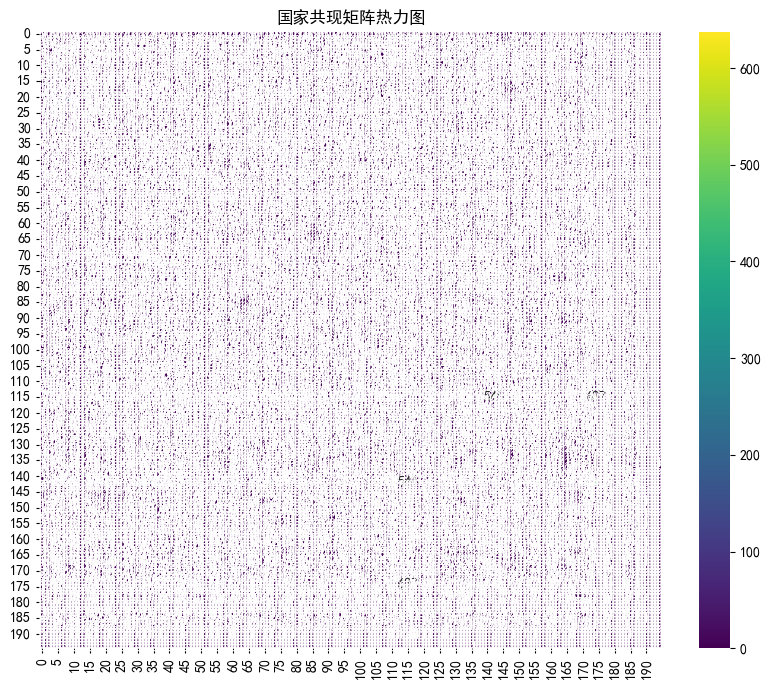

In [16]:
matrix = co_matrix_cntry.values

# 使用seaborn制作热力图
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='viridis', fmt="d")
plt.title("国家共现矩阵热力图")
plt.show()

User: 我注意到这个热力图太复杂了。基于上述的统计结果(matrix)，我希望筛选出来共现次数排名为前30位的国家对称矩阵，请基于matrix对象进行修改，筛选出共现次数排名为前30的国家的对称矩阵热力图。

ChatGPT4.0:
> 为了筛选出共现次数排名前30的国家对，我们首先需要从matrix（原始的共现矩阵）中找到共现次数最高的30个国家对。接下来，我们需要根据这些国家对来创建一个新的对称矩阵，并且仅包含这些国家对。然后，我们可以绘制这个筛选后的矩阵的热力图。下面的步骤展示了如何实现：
> 
> 将原始的共现矩阵matrix转换为一个一维数组，并且记录每个元素对应的行列索引（即国家对）。
> 
> 对这个一维数组进行排序，找到共现次数最高的30个元素及其索引。
> 
> 根据这些索引，从原始的国家列表cntrylst中找到对应的国家名称，创建一个新的国家列表，这个列表只包含出现在最高共现次数的国家对中的国家。
> 
> 使用这个新的国家列表创建一个新的对称矩阵，仅包含这些国家之间的共现次数。
>
> 绘制这个筛选后的对称矩阵的热力图。
> 
> 下面是实现这些步骤的代码：

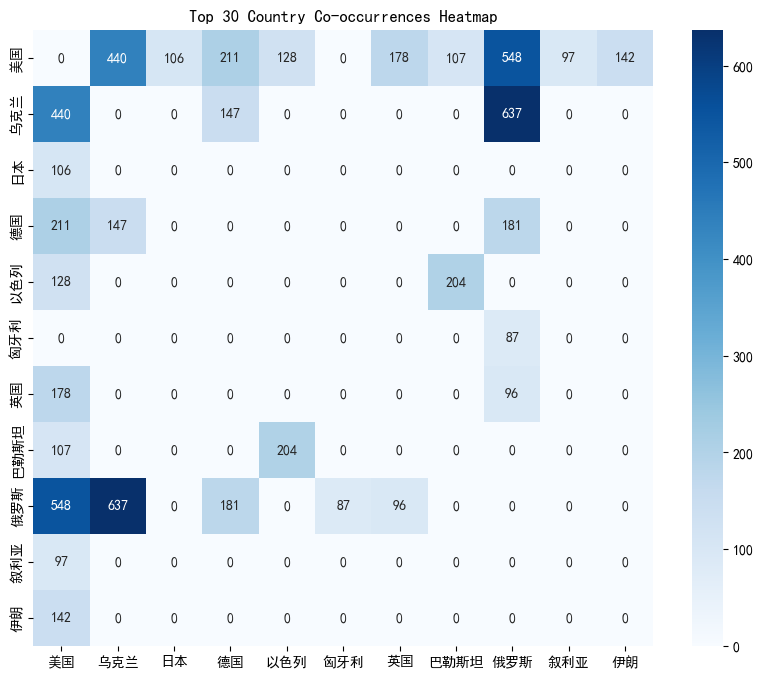

In [17]:
# 将矩阵转换为一维数组，并保留元素的原始索引
flat_matrix = matrix.flatten()
indices = np.unravel_index(range(len(flat_matrix)), matrix.shape)

# 获取共现次数最高的30个元素及其索引
top30_indices = np.argpartition(flat_matrix, -30)[-30:]
top30_flat_indices = np.unravel_index(top30_indices, matrix.shape)

# 创建一个集合，用于存储出现在这些最高共现次数的国家对中的国家
selected_countries = set()
for idx in zip(*top30_flat_indices):
    selected_countries.add(cntry_lst[idx[0]])
    selected_countries.add(cntry_lst[idx[1]])

# 根据selected_countries创建新的DataFrame
selected_countries_lst = list(selected_countries)
new_df = pd.DataFrame(0, index=selected_countries_lst, columns=selected_countries_lst)

# 填充新的DataFrame
for i, j in zip(*top30_flat_indices):
    country1 = cntry_lst[i]
    country2 = cntry_lst[j]
    if country1 in selected_countries and country2 in selected_countries:
        new_df.at[country1, country2] = matrix[i, j]
        new_df.at[country2, country1] = matrix[j, i]

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(new_df, annot=True, cmap='Blues', fmt="d")
plt.title("Top 30 Country Co-occurrences Heatmap")
plt.show()